## Import necessary packages

In [7]:
import numpy as np
import scipy.io
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import nibabel as nib
import os
import datetime
import time
import sys
import warnings
import glob

import seaborn as sns
import functions as funcs
import importlib
from scipy import stats

importlib.reload(funcs)
from matplotlib.colors import ListedColormap

## Global variables

In [8]:
num_parcels = 116
num_cortical_parcels = 100

tau_min = 0
tau_max = 3

pc_alpha = 1
alpha_level = 1e-2/32     # 32 comes from correction for multiple comparisons accross lags (number of lags including lag 0 = 4)

num_subjects_ready = 200
num_networks = 16

network_dic = "{'LH_Vis':[],'LH_Som':[],'LH_Dor':[],'LH_Sal':[], 'LH_Lim':[], 'LH_Con':[], 'LH_Def':[], 'LH_Sub' :[], 'RH_Vis':[],'RH_Som':[],'RH_Dor':[],'RH_Sal':[], 'RH_Lim':[], 'RH_Con':[],'RH_Def':[], 'RH_Sub':[]}"
net_labels = ['LH_Vis','LH_Som','LH_Dor','LH_Sal', 'LH_Lim','LH_Con','LH_Def','LH_Sub', 'RH_Vis','RH_Som','RH_Dor','RH_Sal', 'RH_Lim', 'RH_Con', 'RH_Def', 'RH_Sub']

net_labels_visualization = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att', 'L-Lim','L-Cont','L-Def','L-Sub', 'R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att', 'R-Lim', 'R-Cont', 'R-Def', 'R-Sub']
visualization_labels = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att','L-Lim','L-Cont','L-Def','R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att','R-Lim','R-Cont','R-Def','R-Sub','L-Sub']


# Read cortical and subcortical parcel labels

In [9]:
# Read cortical and subcortical parcel labels
df_cortical = pd.read_csv("Schaefer2018_100Parcels_7Networks_order.txt", '\t', header=None)
df_subcortical = pd.read_csv("Tian_Subcortex_S1_3T_label.txt", '\t', header=None)

Schaefer2018_100Parcels_7Networks_labels = df_cortical[1]
Tian_Subcortex_S1_3T_labels = list(df_subcortical[0])

parcel_labels = []
parcel_labels_short = []

for i in range(0,num_parcels):
    if i < num_cortical_parcels:
        parcel_labels.append(Schaefer2018_100Parcels_7Networks_labels[i][10:])

    else:
        parcel_labels.append(Tian_Subcortex_S1_3T_labels[i-num_cortical_parcels])

    parcel_labels_short.append(parcel_labels[i][0:6])

/home/fahimeh/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


# Standard Colors for Yeo2011 7 Networks

In [10]:
dataframe = pd.read_csv('Yeo2011_7Networks_ColorLUT.txt', delimiter='\t')
Yeo2011_7Networks_ColorLUT = np.array([[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78]])

# Parcel Indices in Each Subnetwork

In [11]:
num_networks = len(net_labels)
num_parcels = len(parcel_labels)

network_parcel_idx= eval(network_dic)

for i in range (0 , num_parcels):

    if i < num_cortical_parcels:
        temp = parcel_labels[i]
        temp_first = temp[0:6]

        if temp_first in network_parcel_idx:
            network_parcel_idx[temp_first].append(i)
    elif i >= num_cortical_parcels  and i<num_cortical_parcels +8:
        network_parcel_idx['RH_Sub'].append(i)
    
    else:
        network_parcel_idx['LH_Sub'].append(i)
network_parcel_idx

{'LH_Vis': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'LH_Som': [9, 10, 11, 12, 13, 14],
 'LH_Dor': [15, 16, 17, 18, 19, 20, 21, 22],
 'LH_Sal': [23, 24, 25, 26, 27, 28, 29],
 'LH_Lim': [30, 31, 32],
 'LH_Con': [33, 34, 35, 36],
 'LH_Def': [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 'LH_Sub': [108, 109, 110, 111, 112, 113, 114, 115],
 'RH_Vis': [50, 51, 52, 53, 54, 55, 56, 57],
 'RH_Som': [58, 59, 60, 61, 62, 63, 64, 65],
 'RH_Dor': [66, 67, 68, 69, 70, 71, 72],
 'RH_Sal': [73, 74, 75, 76, 77],
 'RH_Lim': [78, 79],
 'RH_Con': [80, 81, 82, 83, 84, 85, 86, 87, 88],
 'RH_Def': [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 'RH_Sub': [100, 101, 102, 103, 104, 105, 106, 107]}

# Cortical and subcortical parcel coordinates

In [12]:
# cortical
cortical_parcel_locs_dataframe = pd.read_csv('Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')

cortical_parcel_locs_R = np.reshape(np.array(cortical_parcel_locs_dataframe['R']), (num_cortical_parcels,1))
cortical_parcel_locs_A = np.reshape(np.array(cortical_parcel_locs_dataframe['A']),(num_cortical_parcels,1))
cortical_parcel_locs_S = np.reshape(np.array(cortical_parcel_locs_dataframe['S']), (num_cortical_parcels,1))
cortical_parcel_locs = np.concatenate((cortical_parcel_locs_R, cortical_parcel_locs_A, cortical_parcel_locs_S), axis = 1)

# subcortical
subcortical_parcel_locs_dataframe = pd.read_csv('Tian_Subcortex_S1_3T_COG.txt', delimiter = '\t', header =  None)
subcortical_parcel_locs = np.array(subcortical_parcel_locs_dataframe)

parcel_locs = np.concatenate((cortical_parcel_locs, subcortical_parcel_locs), axis = 0)

# HCP resting-state fMRI data

## Select the Subjects

In [7]:
subjs = scipy.io.loadmat('/home/fahimeh/HCP_Causality_Project/data/HCP/subjs.mat')['subjs']

num_subjects = len(subjs)
selected_subjects_name = []

for s in range(0, num_subjects):
    
    temp_subj = scipy.io.loadmat('/home/fahimeh/HCP_Causality_Project/data/HCP/subjs.mat')['subjs'][s][0]
    selected_subjects_name.append(temp_subj) 

## Load behavioral data

In [8]:
behavioral_df = pd.read_csv('HCP_behavioral_data.csv')

behavioral_subjects_name_list = list(behavioral_df['Subject'])
behavioral_subjects_age_list = list(behavioral_df['Age'])
behavioral_subjects_gender_list = list(behavioral_df['Gender'])

## Load preprocessed fMRI data

In [9]:
fmri_data_rest_1_RL = []
fmri_data_rest_2_RL = []

fmri_data_rest_1_LR = []
fmri_data_rest_2_LR = []

behavioral_selected_subjects_age = []
behavioral_selected_subjects_gender = []

for file in os.listdir("//home/fahimeh/HCP_Causality_Project/data/HCP/coarse"):
    if file.endswith(".npy"):
        path_to_data = os.path.join("/home/fahimeh/HCP_Causality_Project/data/HCP/coarse", file)

        file_name_split = file[:-4].split('_')

        R_L = file_name_split[-1]
        Rest_1_2 = file_name_split[-2]
        subj_name = file_name_split[-3]

        if subj_name in selected_subjects_name:

            if (R_L == 'RL' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_RL.append(np.load(path_to_data).T)

                behavioral_subjects_idx = behavioral_subjects_name_list.index(int(subj_name))
                behavioral_selected_subjects_age.append(behavioral_subjects_age_list[behavioral_subjects_idx])
                behavioral_selected_subjects_gender.append(behavioral_subjects_gender_list[behavioral_subjects_idx])

            elif (R_L == 'RL' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_RL.append(np.load(path_to_data).T)
                
            elif (R_L == 'LR' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_LR.append(np.load(path_to_data).T)

            elif (R_L == 'LR' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_LR.append(np.load(path_to_data).T)
            
print('Number of RL, Rest 1:', len(fmri_data_rest_1_RL) )
print('Number of RL, Rest 2:', len(fmri_data_rest_2_RL) )
print('Number of LR, Rest 1:', len(fmri_data_rest_1_LR) )
print('Number of LR, Rest 2:', len(fmri_data_rest_2_LR) )

Number of RL, Rest 1: 700
Number of RL, Rest 2: 700
Number of LR, Rest 1: 700
Number of LR, Rest 2: 700


## Save/Load data

In [12]:
# np.savez('HCP_Rest_700_Subjects',fmri_data_rest_1_RL = fmri_data_rest_1_RL, fmri_data_rest_2_RL = fmri_data_rest_2_RL, fmri_data_rest_1_LR = fmri_data_rest_1_LR,fmri_data_rest_2_LR = fmri_data_rest_2_LR, selected_subjects_name = selected_subjects_name )
# funcs.import_npz('HCP_Rest_700_Subjects.npz')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# Causality Analysis

##  CaLLTiF Results on HCP Resting-State fMRI

### Load results

In [13]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle = True)
    for varName in Data:
        globals()[varName] = Data[varName]  

In [14]:
import_npz('multipledataset_calltif_hcp_rest.npz')

In [15]:
time_series_graph_hcp_rest_all_subjects = []
time_series_graph_hcp_rest_all_subjects_pvalues = []

hcp_rest_all_graphs = []
hcp_rest_all_graphs_p_values = []

for s in range(0, num_subjects_ready):

    final_graph_org = multipledataset_calltif_hcp_rest_link_matrix[s]['graph']
    p_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['p_matrix'])
    
    # Threshold p_matrix to get graph
    final_graph_new = p_matrix <= alpha_level
    
    val_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['val_matrix'])
    _int_sel_links = multipledataset_calltif_hcp_rest_link_matrix[s]['_int_sel_links']

    # Convert to string graph representation
    graph = funcs.convert_to_string_graph(final_graph_new)

    # Time series graph
    time_series_graph_hcp_rest_all_subjects.append(graph)
    time_series_graph_hcp_rest_all_subjects_pvalues.append(p_matrix)

    # combined graph across lags
    summary_graph, binary_matrix , binary_matrix_p_value= funcs.summarize_across_all_lags_v2(graph, p_matrix)
    
    hcp_rest_all_graphs.append(binary_matrix)
    hcp_rest_all_graphs_p_values.append(binary_matrix_p_value)

## Parcel-Level Graph Parameters

In [17]:
degree_centrality_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
betweenness_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
load_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
eigenvector_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))

out_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
in_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
causal_flow_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))

all_networks_num_edges_from_to_individual_sub = np.zeros((num_networks, num_networks, num_subjects_ready))

all_features_parcels = [0]*num_subjects_ready
for s in range(num_subjects_ready):

    graph = hcp_rest_all_graphs[s]
    G = nx.DiGraph(graph)

    degree_centrality_all_parcels = list(nx.degree_centrality(G).values())
    betweenness_centrality_all_parcels = list(nx.betweenness_centrality(G).values())
    load_centrality_all_parcels = list(nx.load_centrality(G).values())
    eigenvector_centrality_all_parcels = list(nx.eigenvector_centrality(G).values())

    degree_centrality_all_parcels_individual_sub[:,s] = degree_centrality_all_parcels
    betweenness_centrality_all_parcels_individual_sub[:,s] = betweenness_centrality_all_parcels
    load_centrality_all_parcels_individual_sub[:,s] = load_centrality_all_parcels
    eigenvector_centrality_all_parcels_individual_sub[:,s] = eigenvector_centrality_all_parcels

    out_degree_all_parcels = np.mean(graph, axis = 1)
    in_degree_all_parcels = np.mean(graph, axis = 0)
    degree_all_parcels = out_degree_all_parcels + in_degree_all_parcels

    out_degree_all_parcels_individual_sub[:,s] = out_degree_all_parcels
    in_degree_all_parcels_individual_sub[:,s] = in_degree_all_parcels
    degree_all_parcels_individual_sub[:,s] = degree_all_parcels

    causal_flow_all_parcels_individual_sub[:,s] = out_degree_all_parcels - in_degree_all_parcels

    all_features_parcels[s] = np.concatenate((betweenness_centrality_all_parcels,degree_all_parcels,out_degree_all_parcels - in_degree_all_parcels))

    # look at the networks
    all_networks_num_edges_from_to = funcs.network_map(graph,net_labels, network_dic, parcel_labels, num_cortical_parcels)
    all_networks_num_edges_from_to_individual_sub[:,:,s] = all_networks_num_edges_from_to

## Difference in the causal graphs for female and male subjects

### Labels

In [18]:
target = behavioral_selected_subjects_gender[0:num_subjects_ready]

print('number of female ready subjects:', target.count('F'))
print('number of male ready subjects:', target.count('M'))

number of female ready subjects: 106
number of male ready subjects: 94


### Data

In [19]:
female_idx = np.where(np.array(target) == 'F')[0]
male_idx = np.where(np.array(target) == 'M')[0]

### Parcel Graph Parameters

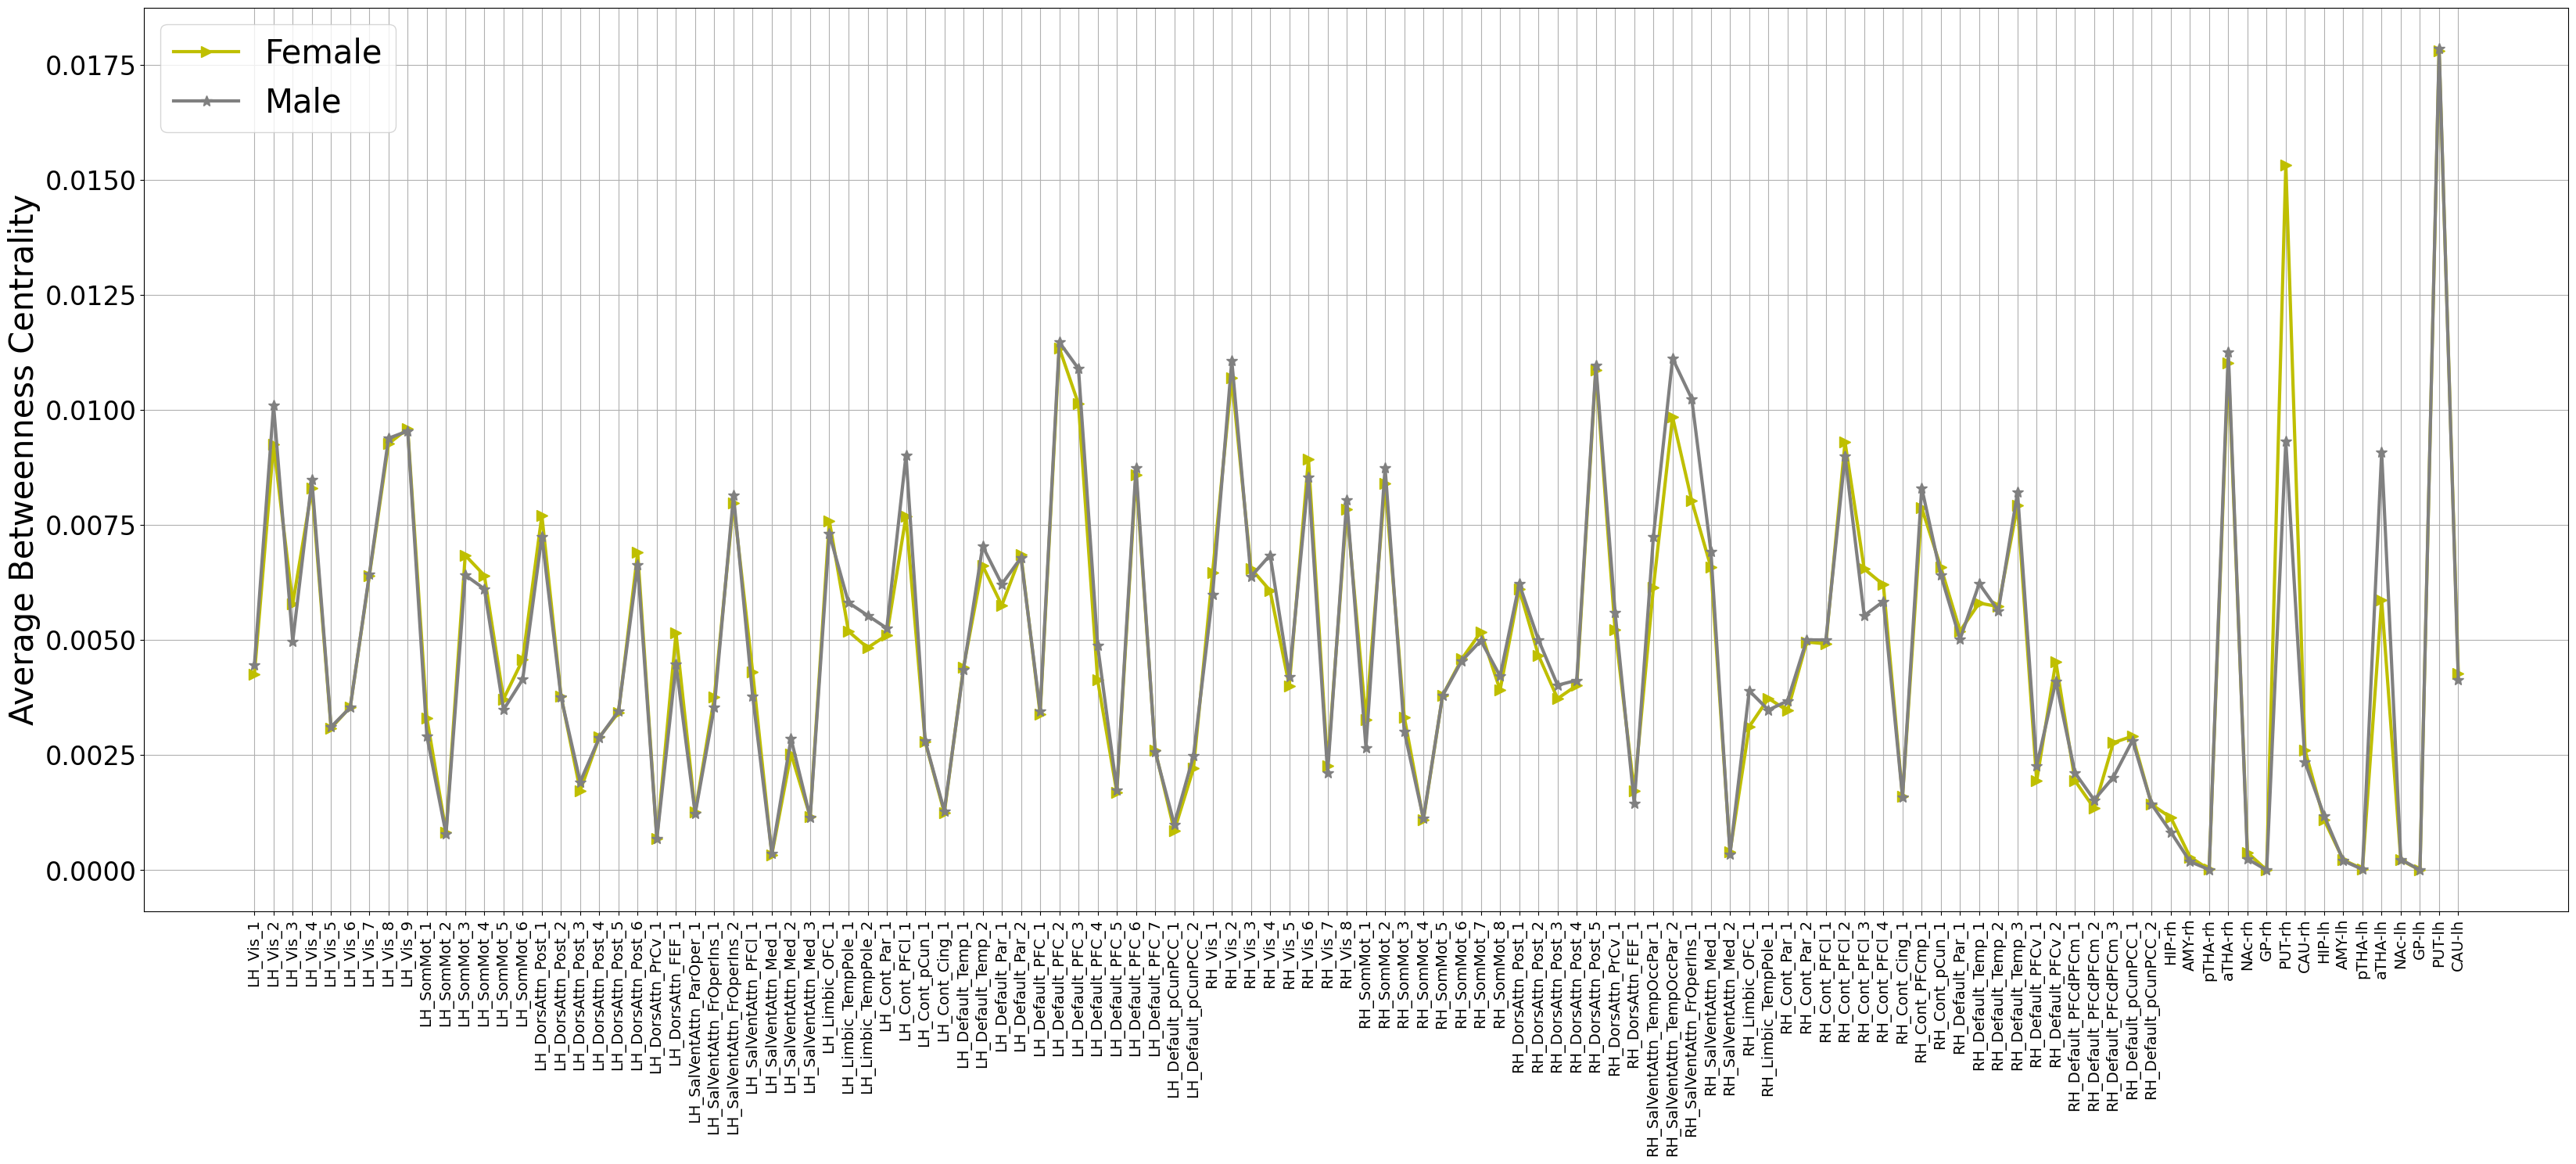

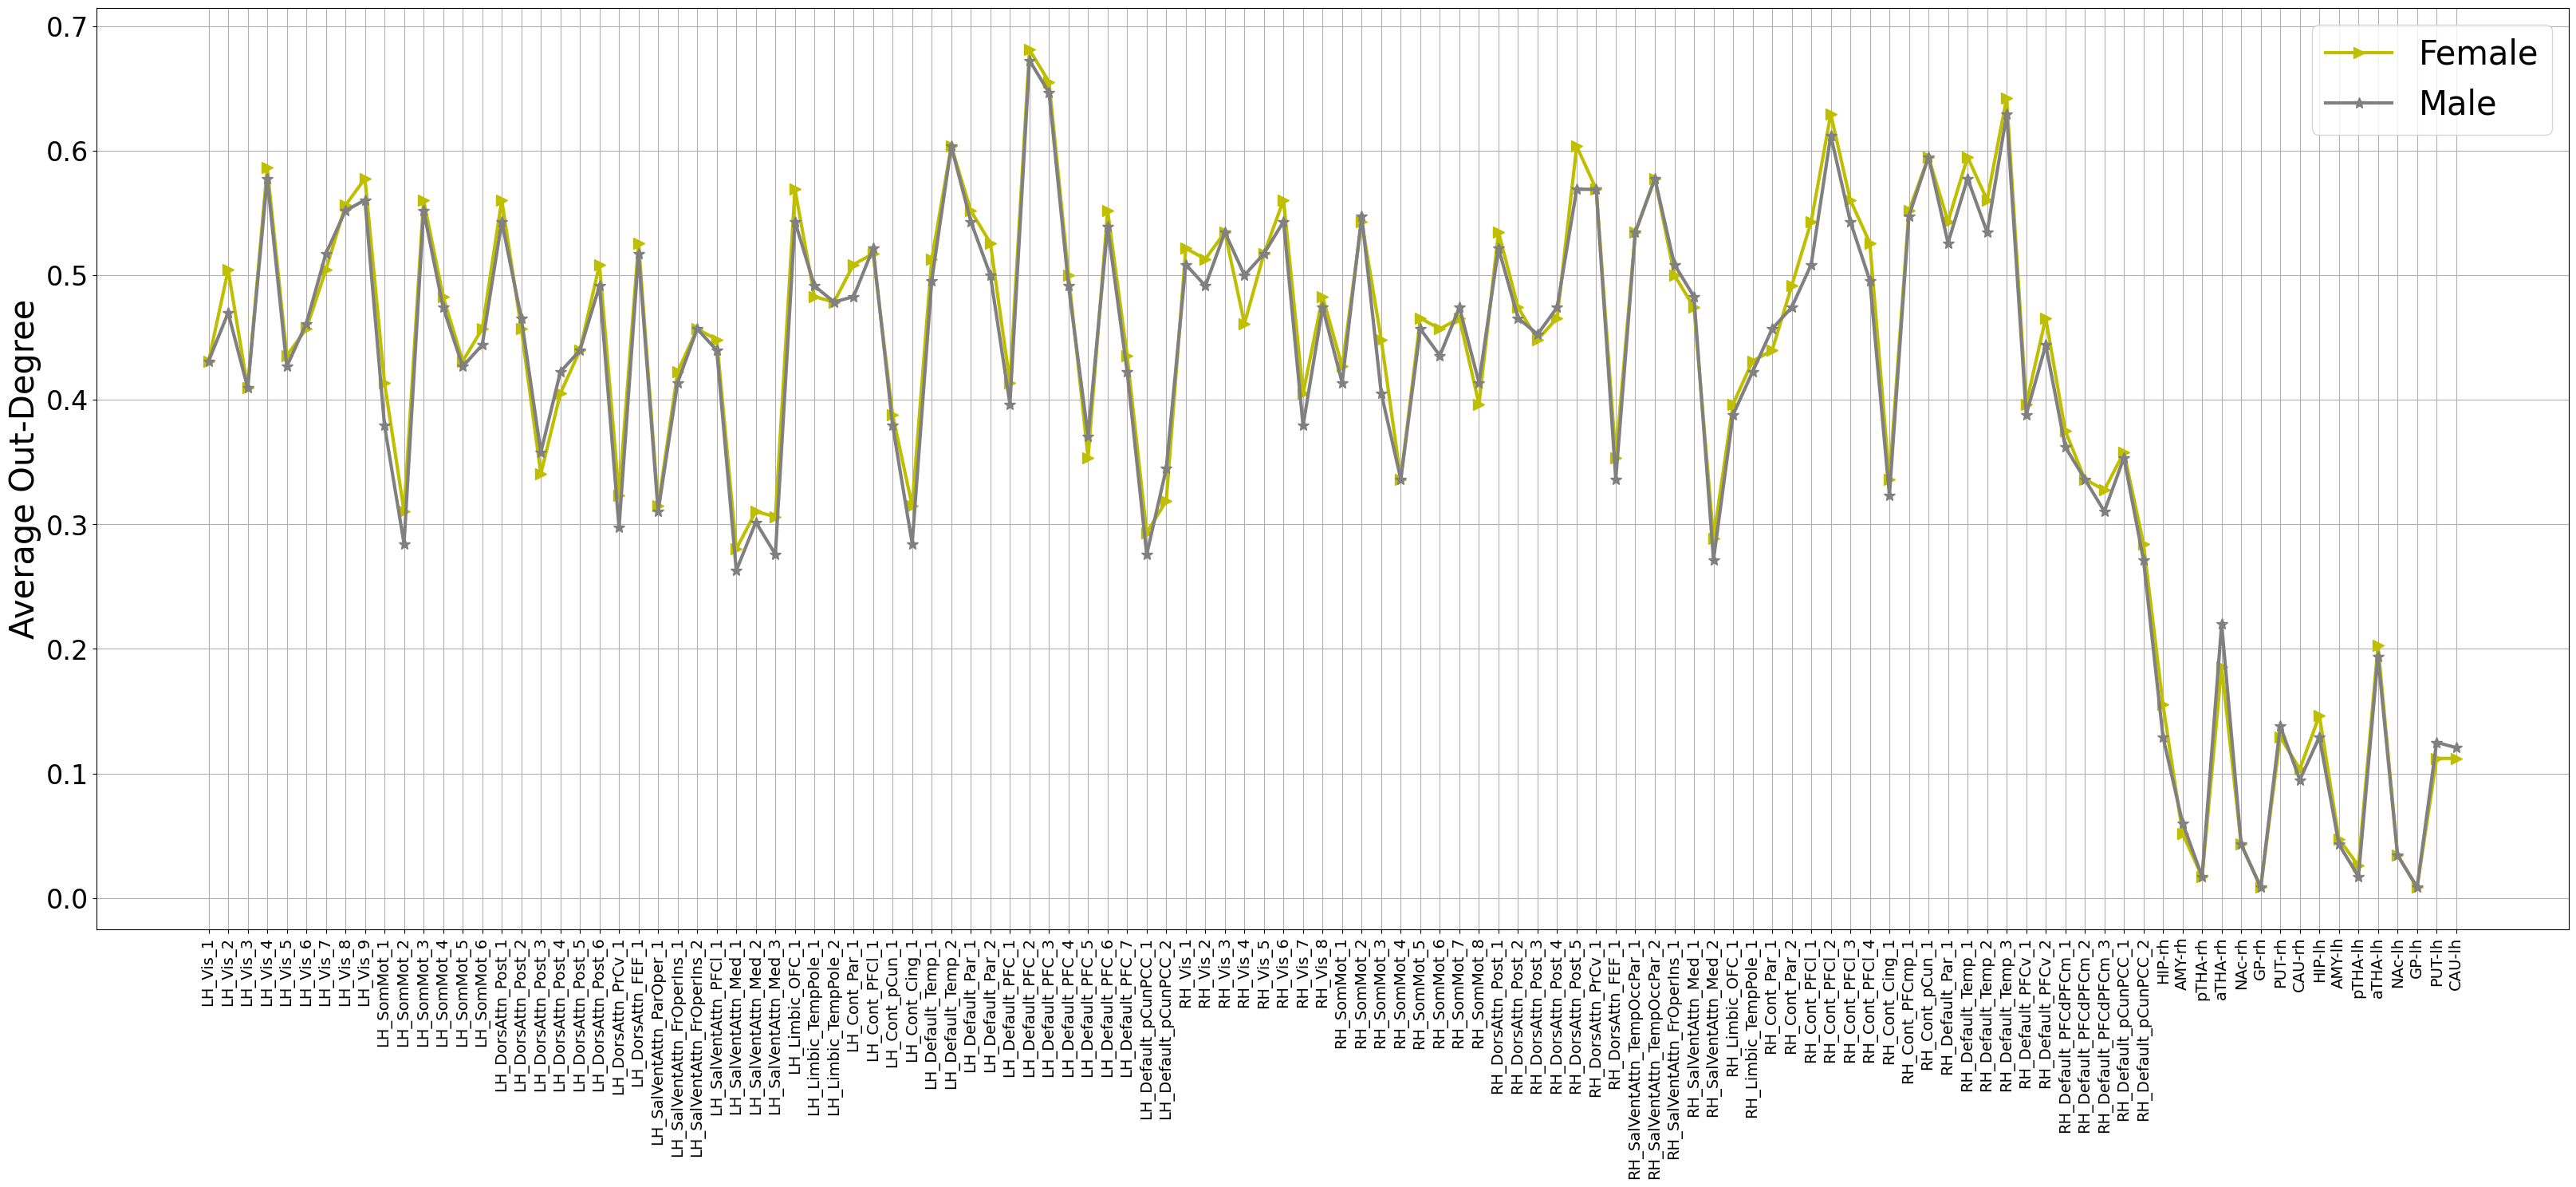

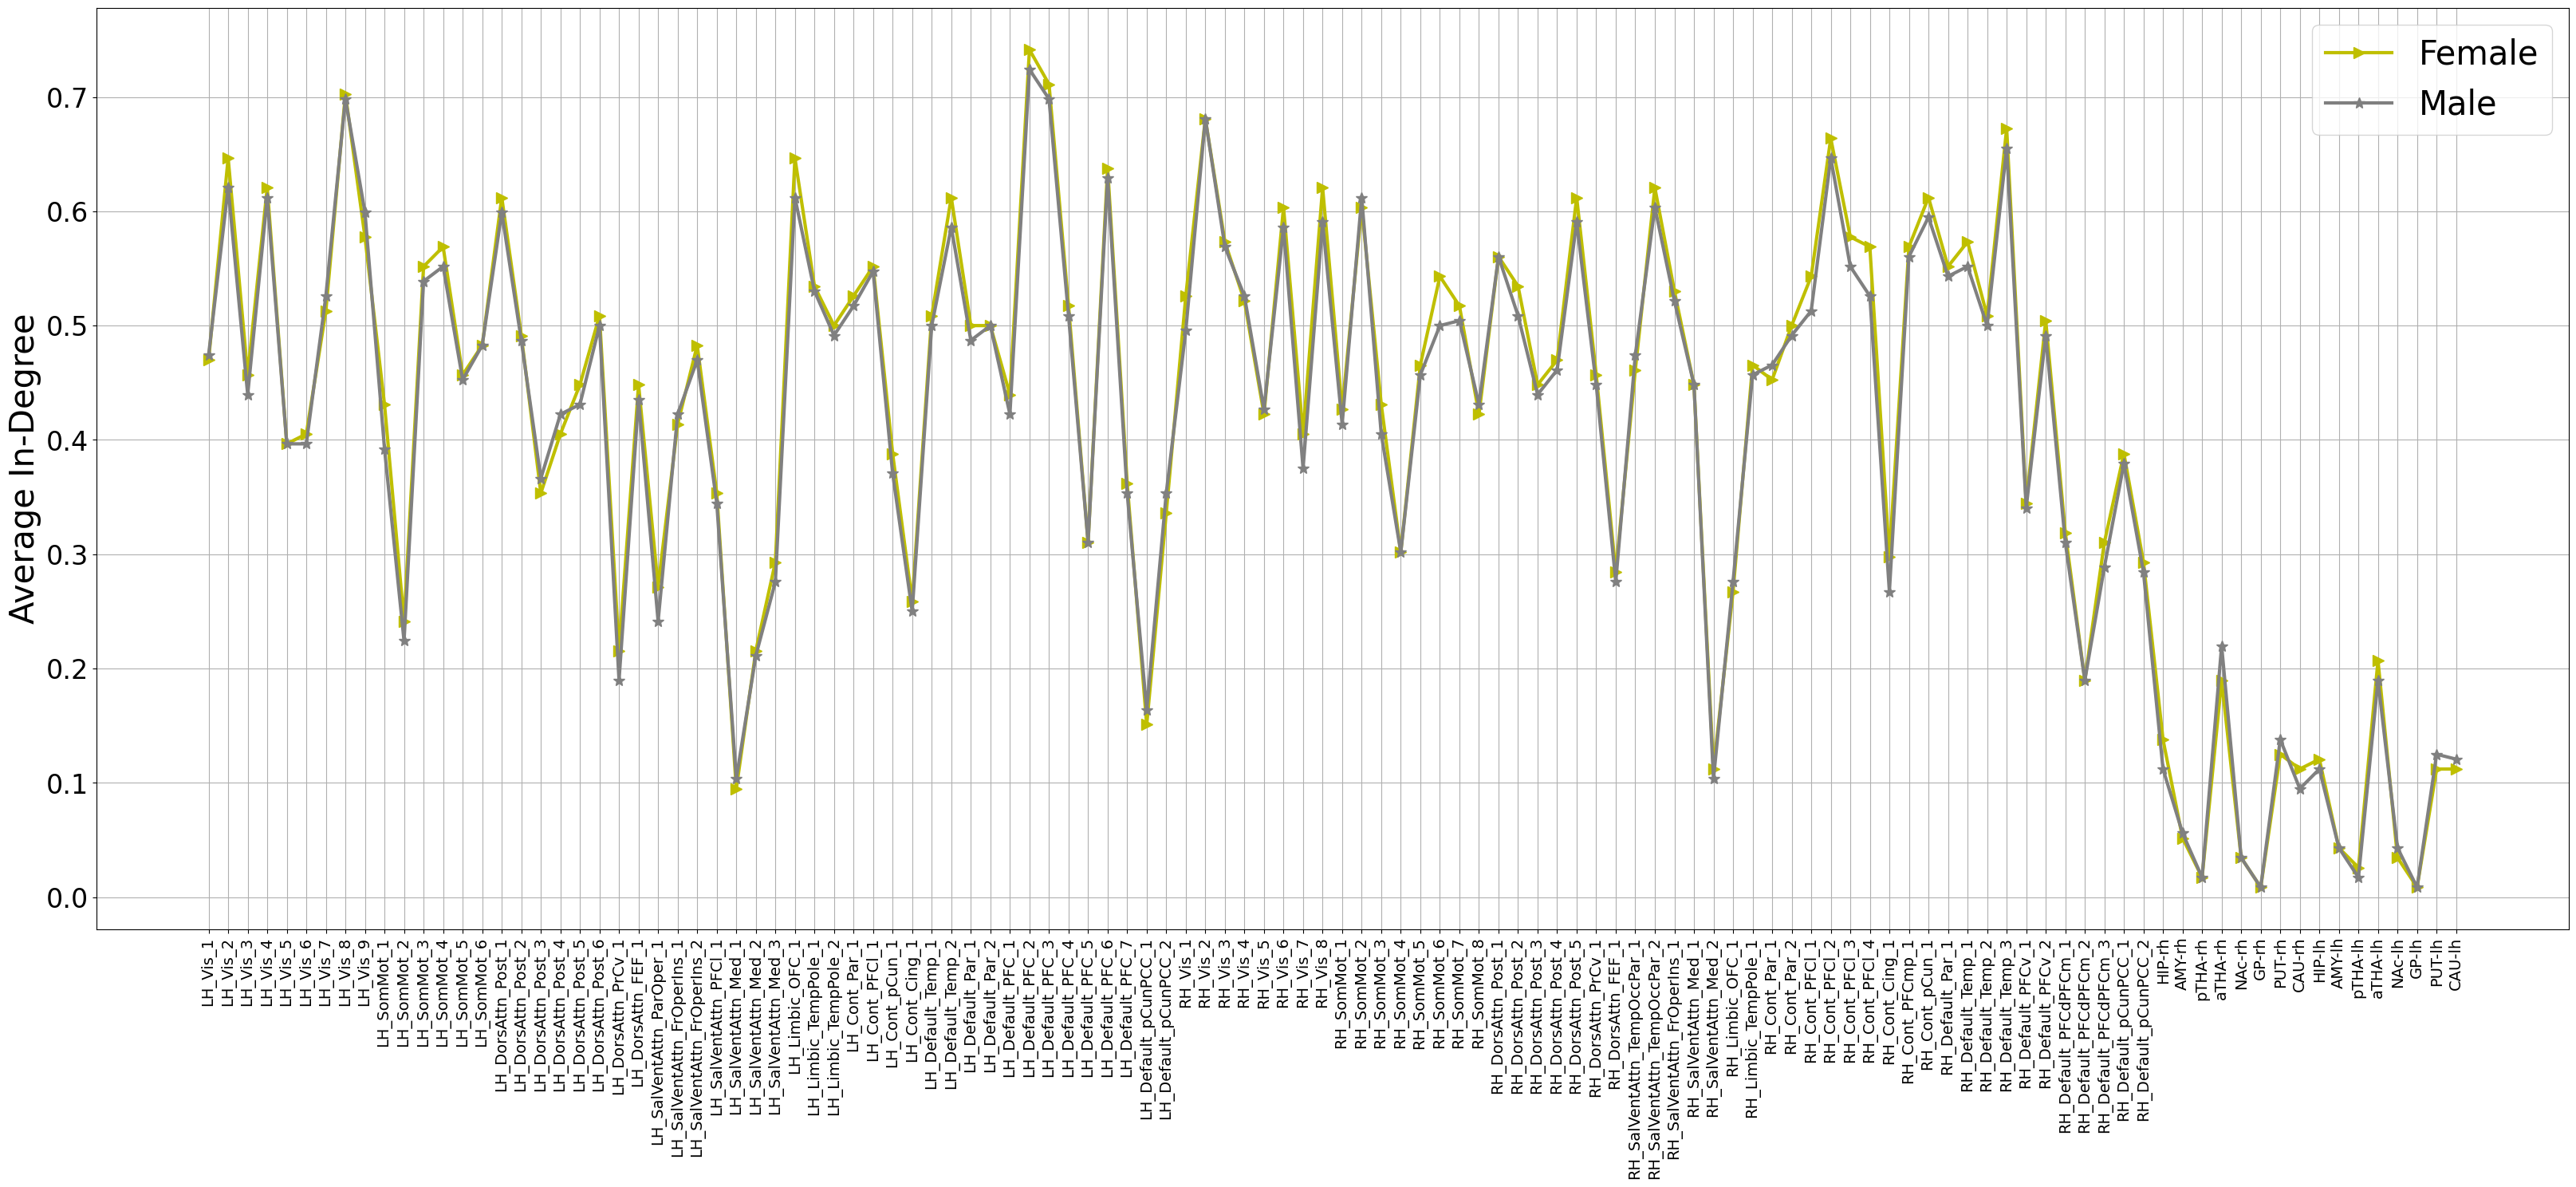

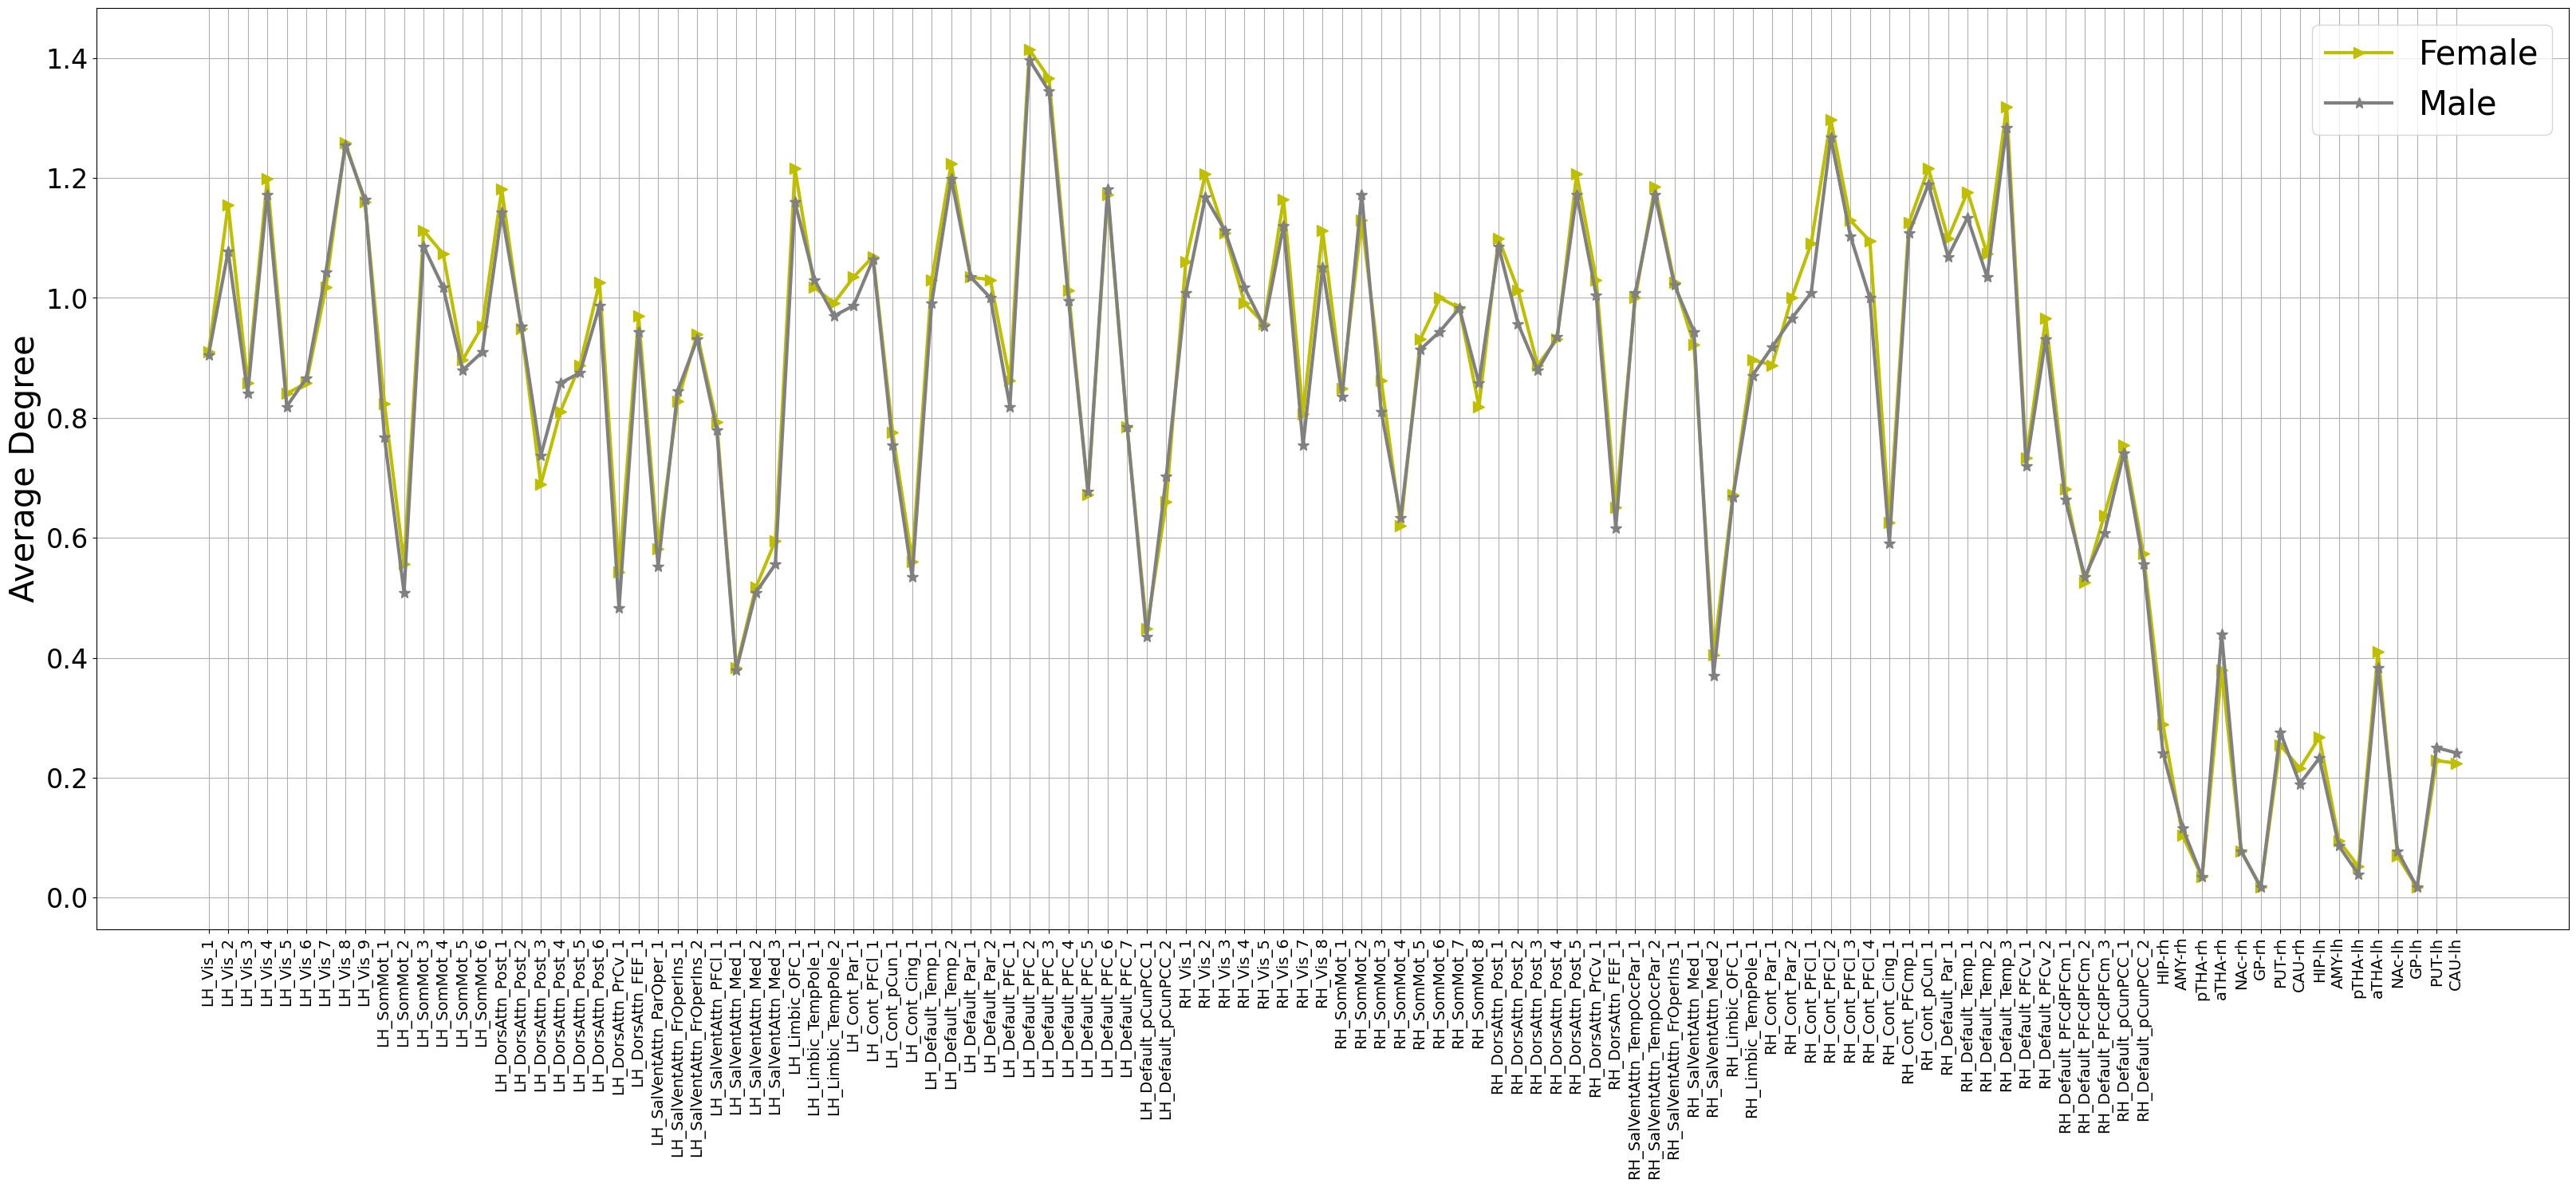

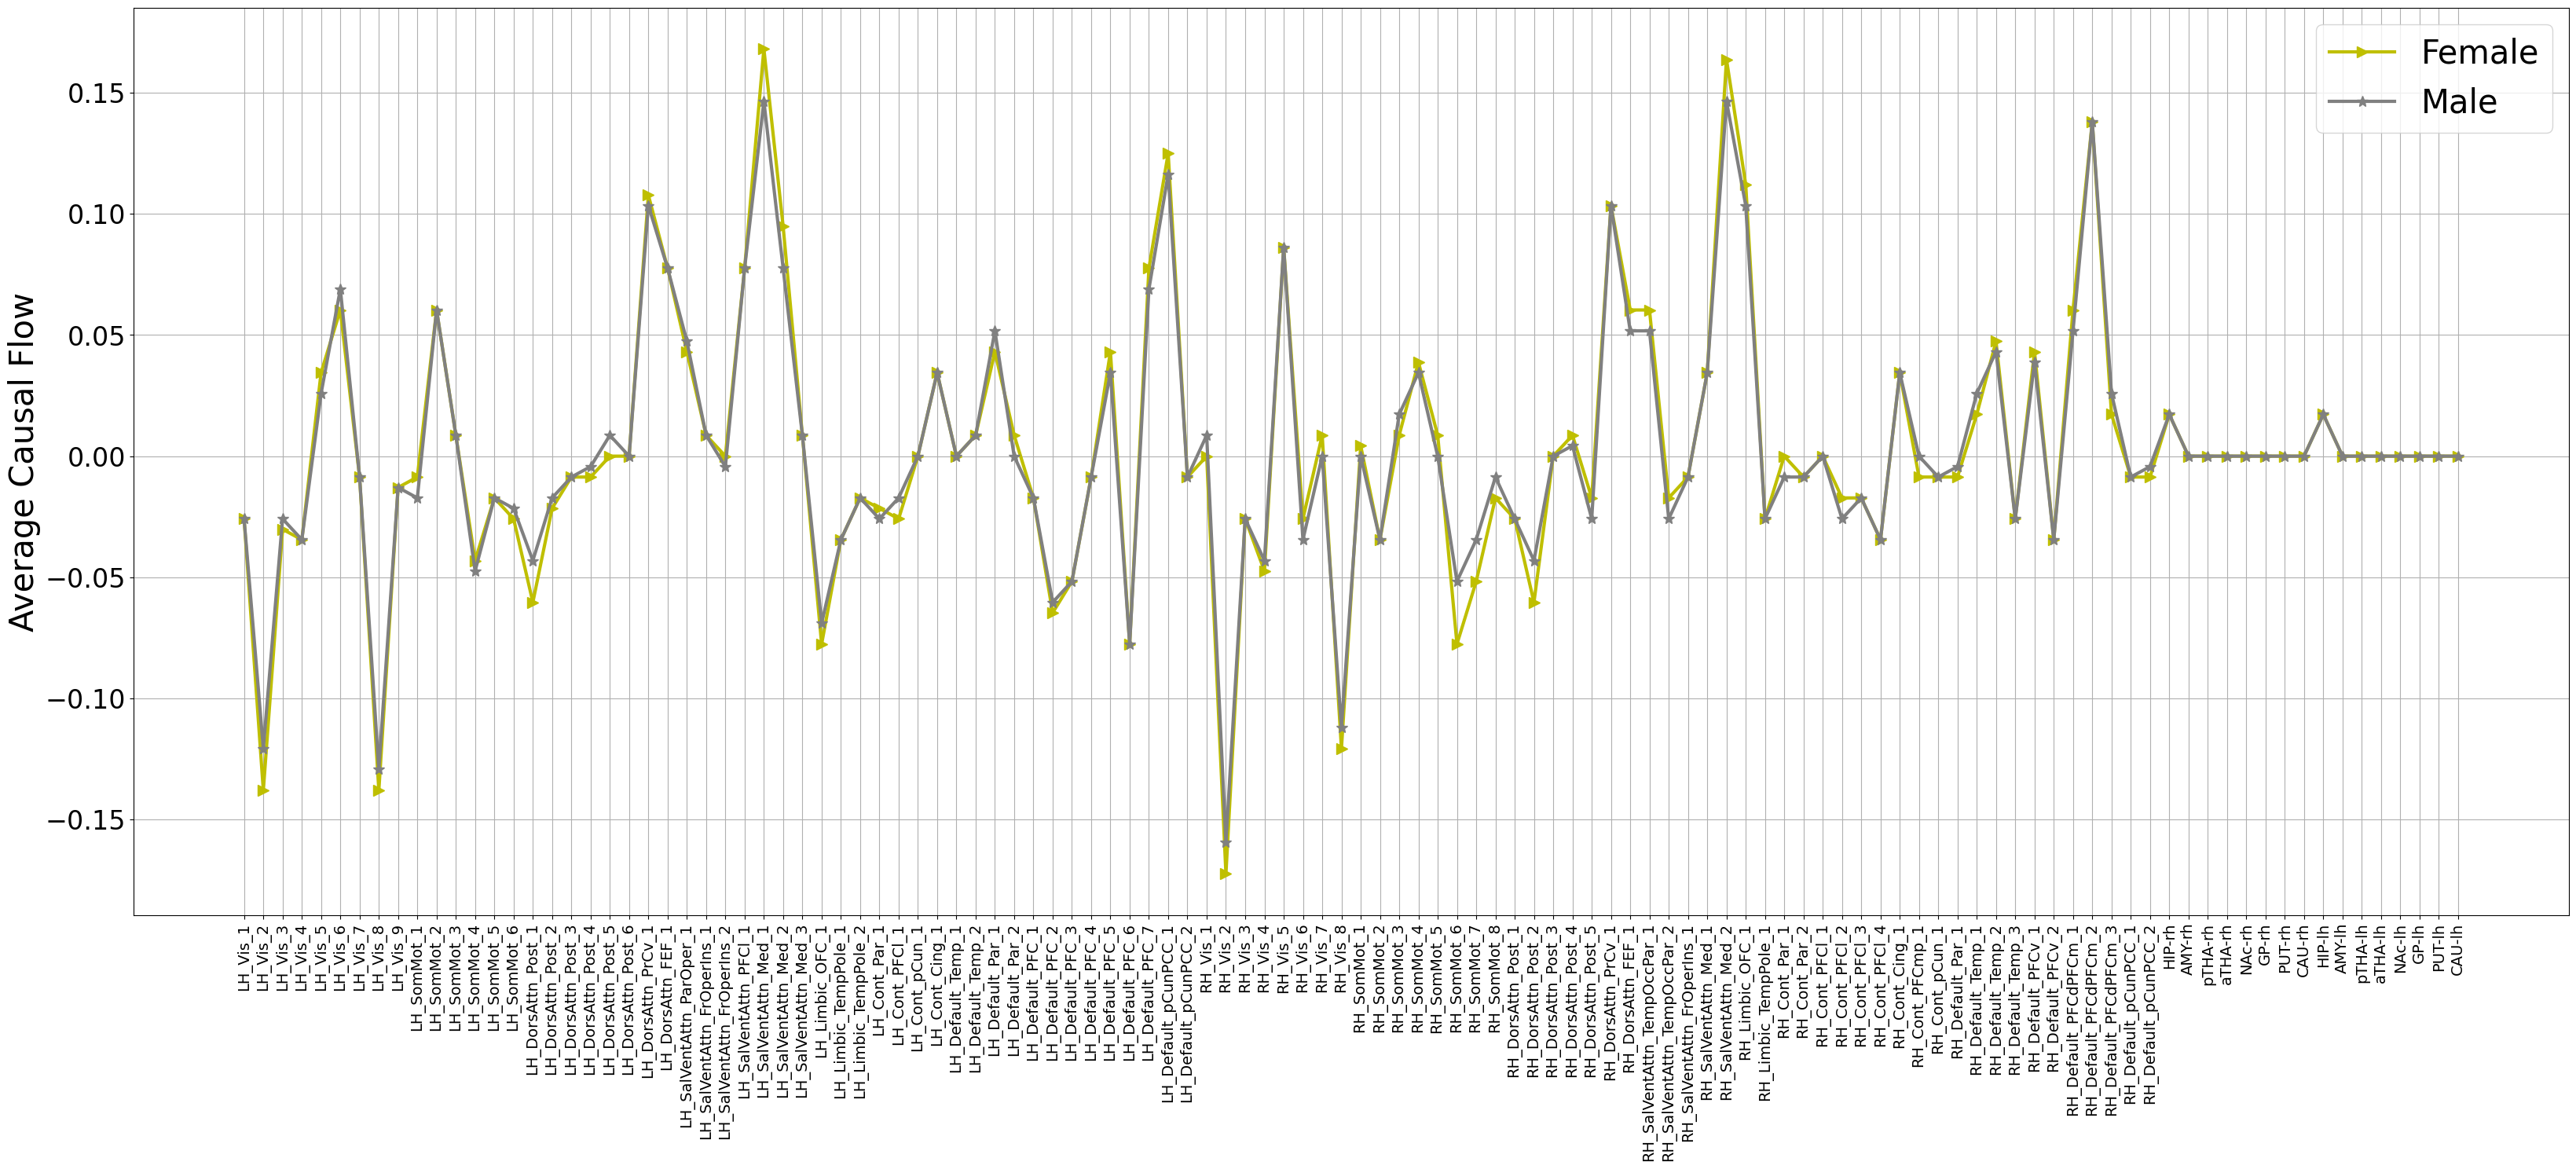

In [20]:
plt.figure(figsize = (40,15))
p = plt.plot(np.median(np.array(betweenness_centrality_all_parcels_individual_sub)[:,list(female_idx)], axis = 1), linewidth = 3, marker = '>', markersize = 10, color= 'y')
p = plt.plot(np.median(np.array(betweenness_centrality_all_parcels_individual_sub)[:,list(male_idx)], axis = 1), linewidth = 3, marker = '*',markersize = 10, color = 'gray')
plt.grid()

plt.ylabel('Average Betweenness Centrality', fontsize = 30)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 24 )
plt.legend(['Female','Male'], fontsize = 30)


plt.figure(figsize = (40,15))
p = plt.plot(np.median(np.array(out_degree_all_parcels_individual_sub)[:,list(female_idx)], axis = 1), linewidth = 3, marker = '>', markersize = 10, color = 'y')
p = plt.plot(np.median(np.array(out_degree_all_parcels_individual_sub)[:,list(male_idx)], axis = 1), linewidth = 3, marker = '*', markersize = 10, color = 'gray')
plt.grid()
plt.ylabel('Average Out-Degree', fontsize = 30)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 24 )
plt.legend(['Female','Male'], fontsize = 30)


plt.figure(figsize = (40,15))
p = plt.plot(np.median(np.array(in_degree_all_parcels_individual_sub)[:,list(female_idx)], axis = 1), linewidth = 3, marker = '>', markersize = 10, color = 'y')
p = plt.plot(np.median(np.array(in_degree_all_parcels_individual_sub)[:,list(male_idx)], axis = 1), linewidth = 3, marker = '*', markersize = 10, color = 'gray')
plt.grid()
plt.ylabel('Average In-Degree', fontsize = 30)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 24 )
plt.legend(['Female','Male'], fontsize = 30)

plt.figure(figsize = (40,15))
p = plt.plot(np.median(np.array(degree_all_parcels_individual_sub)[:,list(female_idx)], axis = 1), linewidth = 3, marker = '>', markersize = 10, color = 'y')
p = plt.plot(np.median(np.array(degree_all_parcels_individual_sub)[:,list(male_idx)], axis = 1), linewidth = 3, marker = '*', markersize = 10, color = 'gray')
plt.grid()
plt.ylabel('Average Degree', fontsize = 30)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 24 )
plt.legend(['Female','Male'], fontsize = 30)


plt.figure(figsize = (40,15))
p = plt.plot(np.median(np.array(causal_flow_all_parcels_individual_sub)[:,list(female_idx)], axis = 1), linewidth = 3, marker = '>', markersize = 10, color = 'y')
p = plt.plot(np.median(np.array(causal_flow_all_parcels_individual_sub)[:,list(male_idx)], axis = 1), linewidth = 3, marker = '*', markersize = 10, color = 'gray')
plt.grid()
plt.ylabel('Average Causal Flow', fontsize = 30)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 24 )
plt.legend(['Female','Male'], fontsize = 30)


### Graph Density

In [21]:
graph_density_female = []
for s in range(0,len(female_idx)):
    graph_density_female.append(np.mean(np.array(hcp_rest_all_graphs)[female_idx[s]]))
                                
graph_density_male = []
for s in range(0,len(male_idx)):
    graph_density_male.append(np.mean(np.array(hcp_rest_all_graphs)[male_idx[s]]))

RanksumsResult(statistic=1.3670956843822692, pvalue=0.08579765790734656)


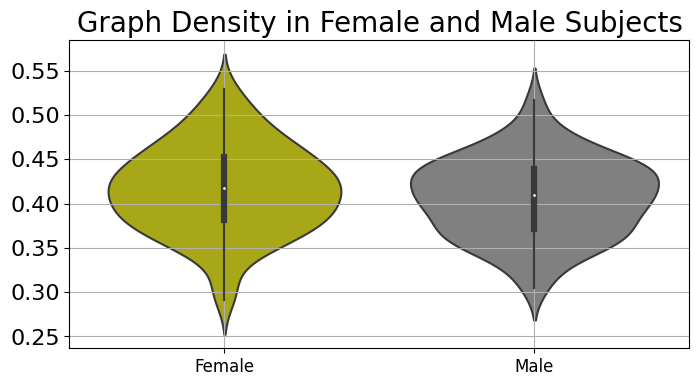

In [22]:
plt.figure(figsize = (8,4))
violin_parts = sns.violinplot([graph_density_female,graph_density_male], showmedians = True, showextrema = True, palette= ['y', 'gray'] )
plt.grid()
plt.title('Graph Density in Female and Male Subjects', fontsize = 20)
plt.xticks(np.arange(0,2), labels = ['Female', 'Male'], rotation = 'horizontal',fontsize = 12)
h = plt.yticks(fontsize = 16)

test = scipy.stats.ranksums(graph_density_female, graph_density_male, alternative='greater')
print(test)

### Degree and Causal Flow

In [27]:
degree_parcels_female = degree_all_parcels_individual_sub[:,female_idx].flatten()
degree_parcels_male = degree_all_parcels_individual_sub[:,male_idx].flatten()

degree_male_female = [degree_parcels_female,degree_parcels_male]
causal_flow_male_female = [causal_flow_parcels_female,causal_flow_parcels_male]

RanksumsResult(statistic=4.542701586452709, pvalue=2.776892226339174e-06) RanksumsResult(statistic=-0.2403796572752536, pvalue=0.8100359470842097)


Text(0.2, 0.38, '-----ns-----')

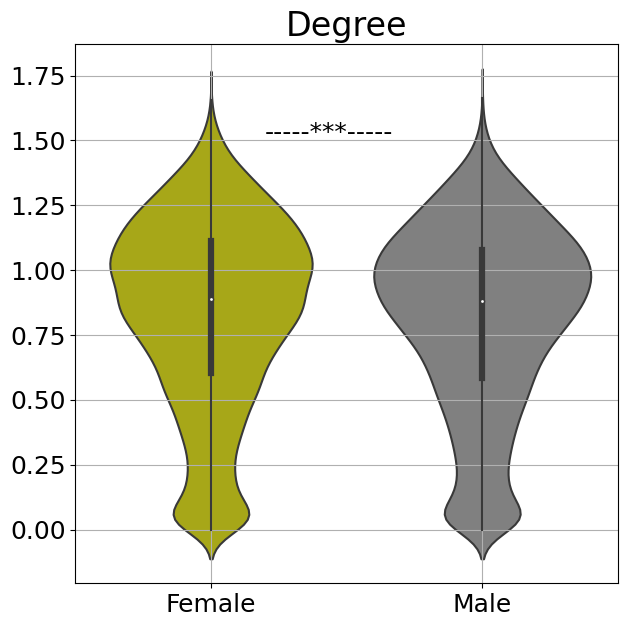

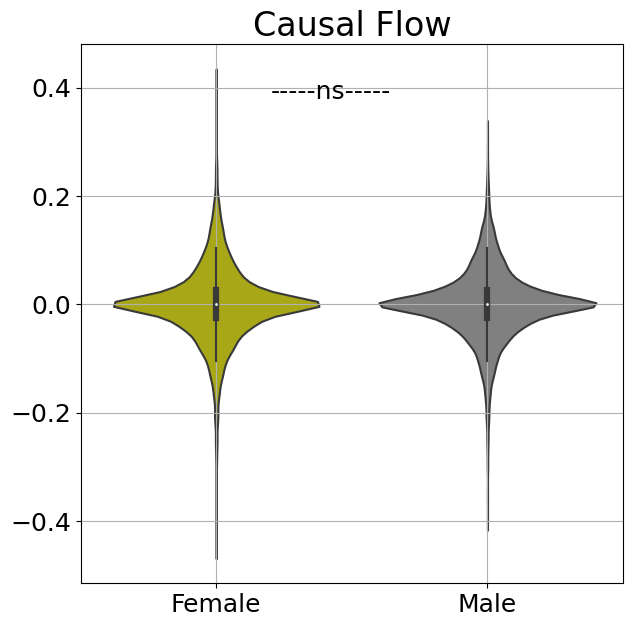

In [28]:
plt.figure(figsize = (7,7))

violin_parts = sns.violinplot(degree_male_female, showmedians = True, showextrema = True, palette=['y','gray'] )

plt.grid()
plt.title('Degree', fontsize = 24)
plt.xticks(np.arange(0,2), labels = ['Female', 'Male'], rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)
test_degree = scipy.stats.ranksums(degree_parcels_female, degree_parcels_male, alternative='greater')

pvalue = '-----***-----'
y_position = 1.5
plt.text(x=0.2, y=y_position, s=pvalue, fontsize=18)

plt.figure(figsize = (7,7))
violin_parts = sns.violinplot(causal_flow_male_female, showmedians = True, showextrema = True , palette=['y','gray'] )
plt.grid()
plt.title('Causal Flow', fontsize = 24)
plt.xticks(np.arange(0,2), labels = ['Female', 'Male'], rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)

test_causal_flow = scipy.stats.ranksums(causal_flow_parcels_female,causal_flow_parcels_male, alternative='two-sided')
print(test_degree, test_causal_flow)

pvalue = '-----ns-----'
y_position = 0.38
plt.text(x=0.2, y=y_position, s=pvalue, fontsize=18)


### Sub-Network Graphs

In [29]:
X_subnetworks = all_networks_num_edges_from_to_individual_sub.transpose(2,0,1)
X_subnetworks = np.reshape(X_subnetworks,((num_networks)*(num_networks),-1)).T

#### Sub-Network Parameters

In [30]:
X_betweenness = [0]*num_subjects_ready
X_degree =  [0]*num_subjects_ready
X_out_degree =  [0]*num_subjects_ready
X_in_degree =  [0]*num_subjects_ready
X_causal_flow =  [0]*num_subjects_ready
X_subnetworks_all_features = [0]*num_subjects_ready

for s in range(0, num_subjects_ready):

    matrix = all_networks_num_edges_from_to_individual_sub[:, :,s]

    G = nx.DiGraph(matrix)
    X_betweenness[s] = list(nx.betweenness_centrality(G).values())
    X_out_degree[s] = np.mean(matrix, axis = 1)
    X_in_degree[s] = np.mean(matrix, axis = 0)
    X_degree[s] = X_out_degree[s] + X_in_degree[s]
    X_causal_flow[s] = X_out_degree[s] - X_in_degree[s]

    X_subnetworks_all_features[s] = np.concatenate((X_betweenness[s], X_degree[s], X_causal_flow[s]))


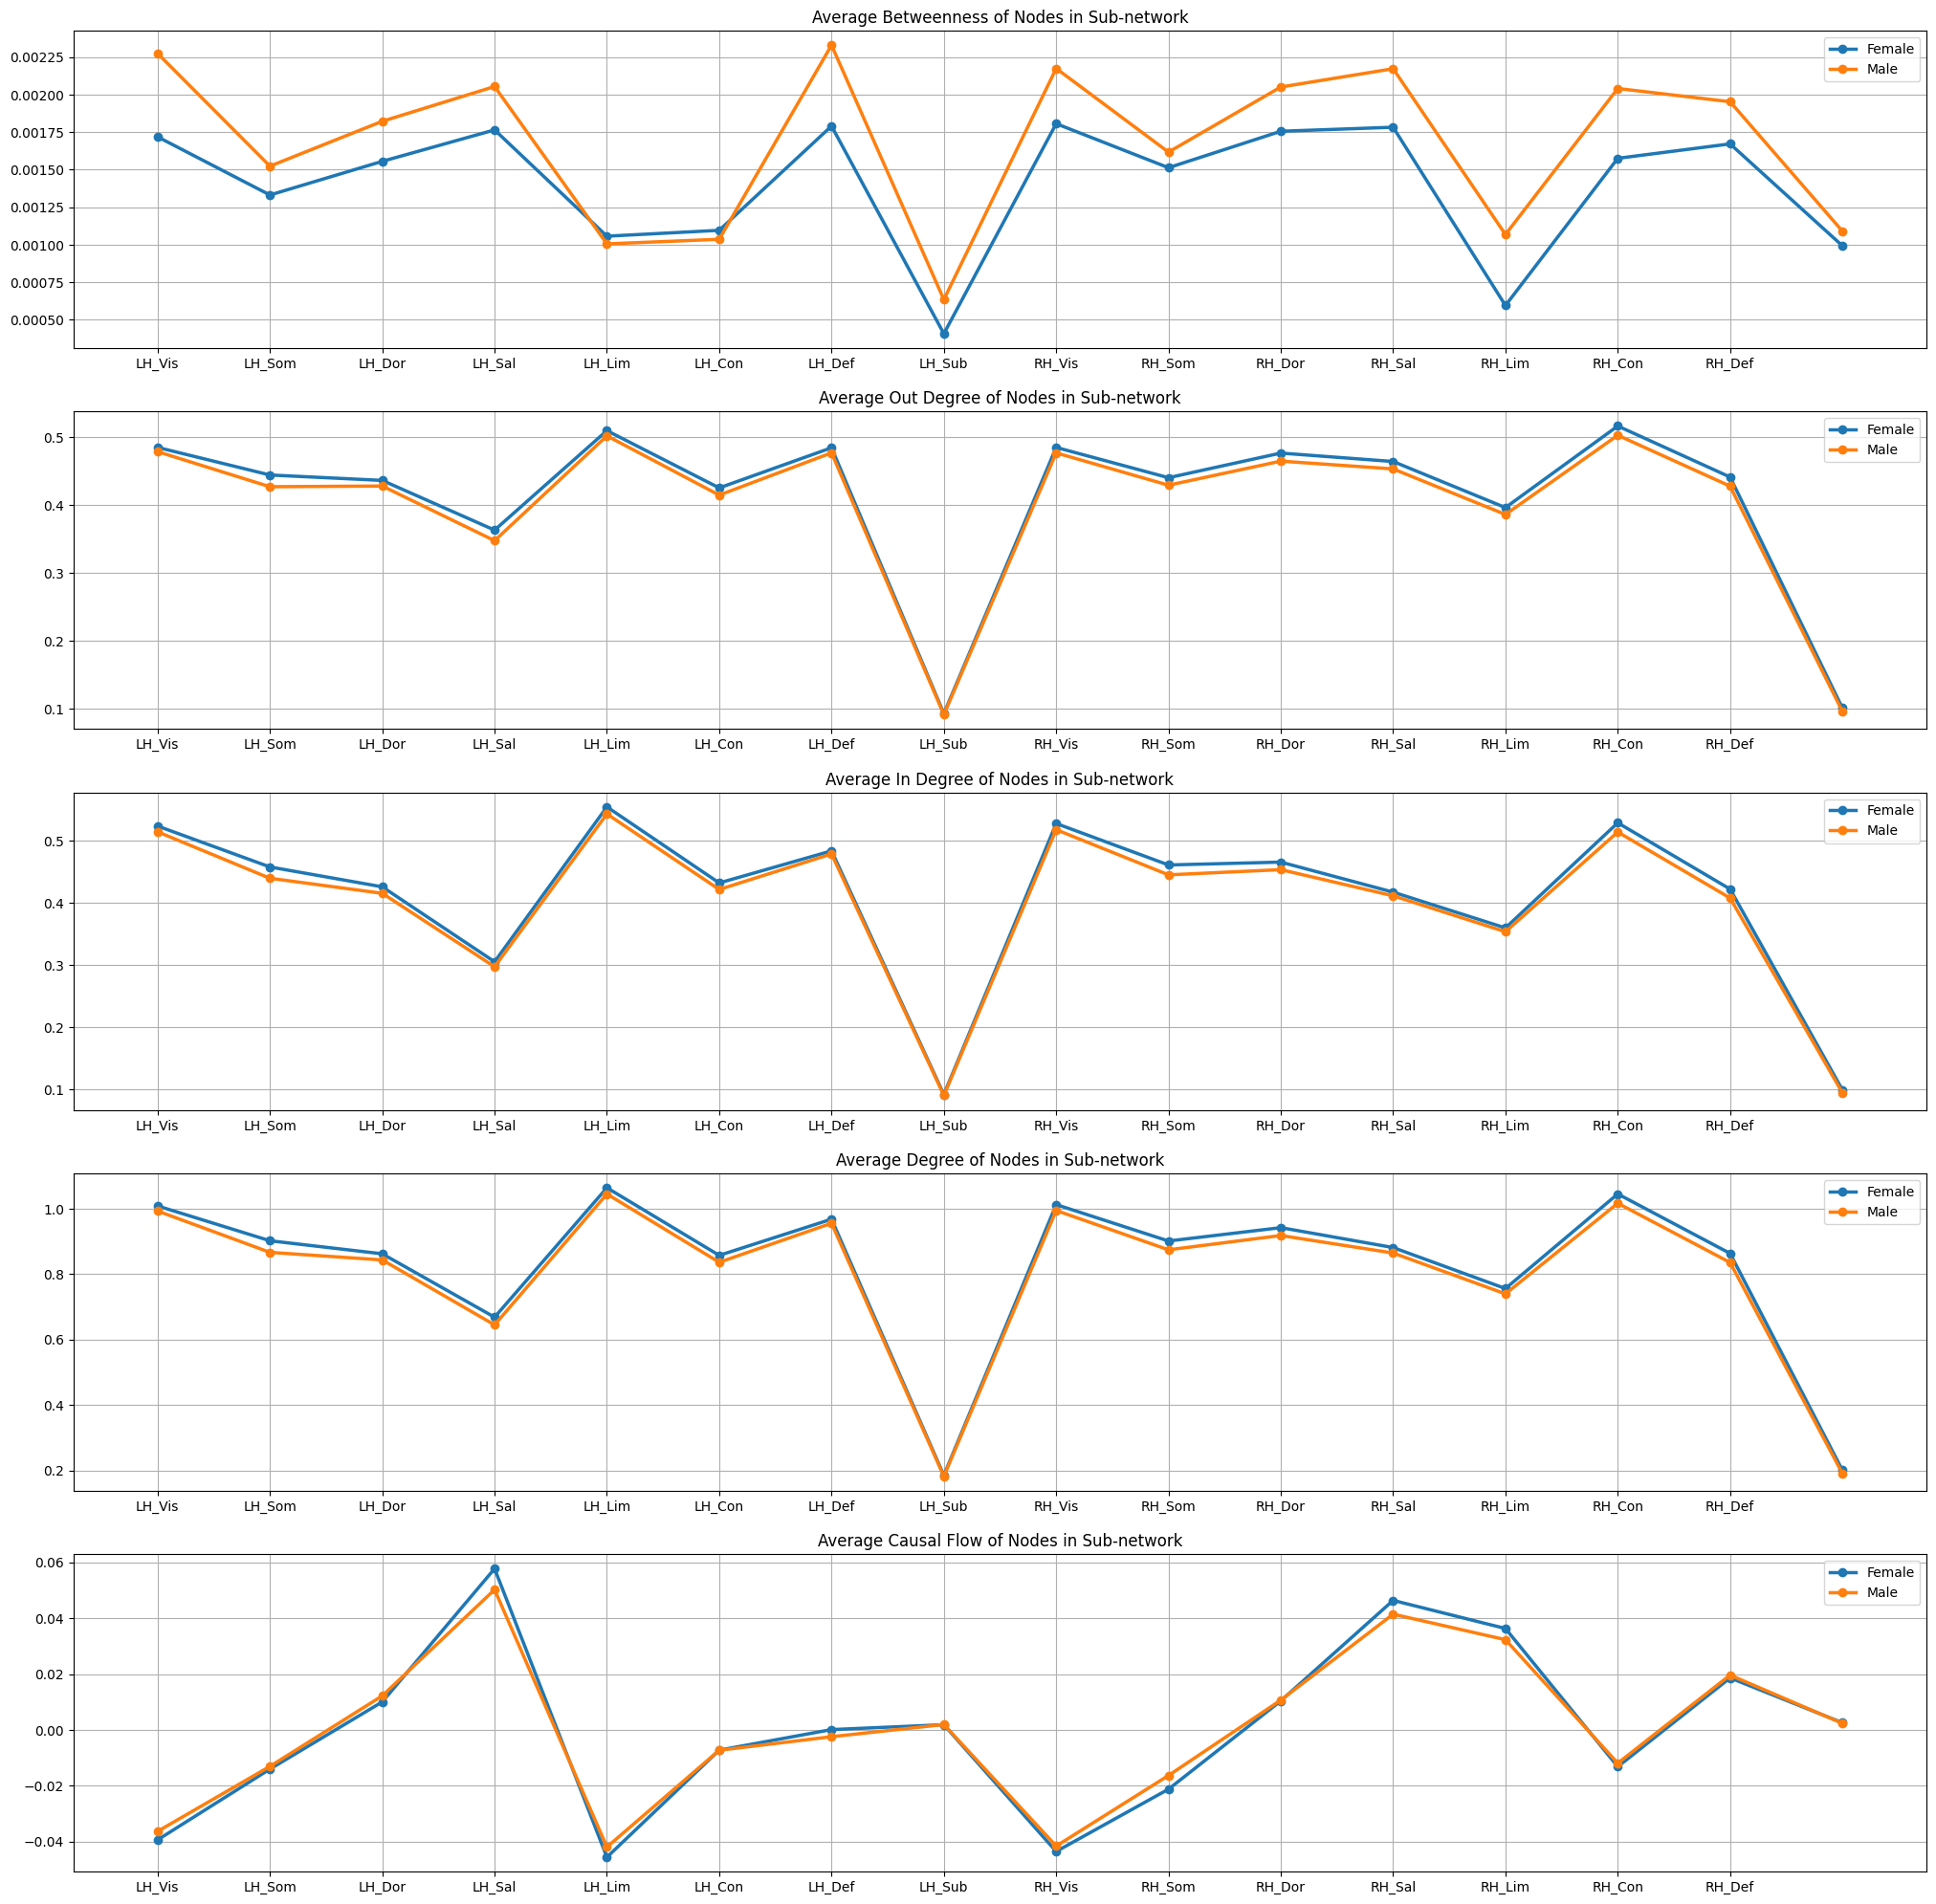

In [31]:
plt.figure(figsize = (25,25))
ax = plt.subplot(5,1,1)
p = plt.plot(np.mean(np.array(X_betweenness)[list(female_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
p = plt.plot(np.mean(np.array(X_betweenness)[list(male_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
plt.grid()
ax.set_xticks(np.arange(len(net_labels[:-1])), labels = net_labels[:-1])
plt.title('Average Betweenness of Nodes in Sub-network')
plt.legend(['Female','Male'])

ax = plt.subplot(5,1,2)
p = plt.plot(np.mean(np.array(X_out_degree)[list(female_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
p = plt.plot(np.mean(np.array(X_out_degree)[list(male_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
plt.grid()
ax.set_xticks(np.arange(len(net_labels[:-1])), labels = net_labels[:-1])
plt.title('Average Out Degree of Nodes in Sub-network')
plt.legend(['Female','Male'])

ax = plt.subplot(5,1,3)
p = plt.plot(np.mean(np.array(X_in_degree)[list(female_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
p = plt.plot(np.mean(np.array(X_in_degree)[list(male_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
plt.grid()
ax.set_xticks(np.arange(len(net_labels[:-1])), labels = net_labels[:-1])
plt.title('Average In Degree of Nodes in Sub-network')
plt.legend(['Female','Male'])

ax = plt.subplot(5,1,4)
p = plt.plot(np.mean(np.array(X_degree)[list(female_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
p = plt.plot(np.mean(np.array(X_degree)[list(male_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
plt.grid()
ax.set_xticks(np.arange(len(net_labels[:-1])), labels = net_labels[:-1])
plt.title('Average Degree of Nodes in Sub-network')
plt.legend(['Female','Male'])

ax = plt.subplot(5,1,5)
p = plt.plot(np.mean(np.array(X_causal_flow)[list(female_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
p = plt.plot(np.mean(np.array(X_causal_flow)[list(male_idx),:].T, axis = 1), linewidth = 2.5, marker = 'o')
plt.grid()
ax.set_xticks(np.arange(len(net_labels[:-1])), labels = net_labels[:-1])
plt.title('Average Causal Flow of Nodes in Sub-network')
plt.legend(['Female','Male'])

##### Degree

RanksumsResult(statistic=2.8427565560520387, pvalue=0.0022362609177223242)


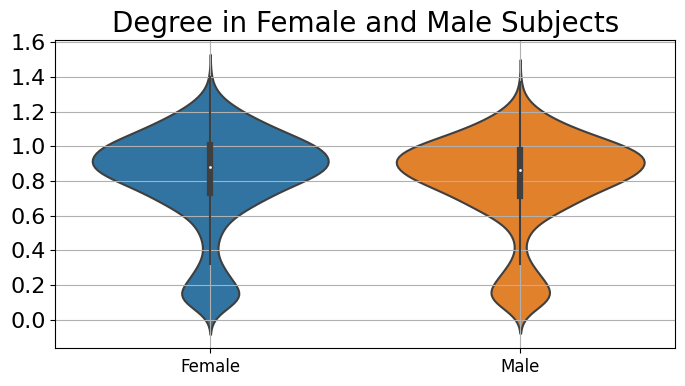

In [32]:
degree_subnetwork_female = np.array(X_degree)[female_idx,:].flatten()
degree_subnetwork_male = np.array(X_degree)[male_idx,:].flatten()

plt.figure(figsize = (8,4))
violin_parts = sns.violinplot([degree_subnetwork_female,degree_subnetwork_male], showmedians = True, showextrema = True )
plt.grid()
plt.title('Degree in Female and Male Subjects', fontsize = 20)
plt.xticks(np.arange(0,2), labels = ['Female', 'Male'], rotation = 'horizontal',fontsize = 12)
h = plt.yticks(fontsize = 16)

test = scipy.stats.ranksums(degree_subnetwork_female, degree_subnetwork_male, alternative='greater')
print(test)

##### Causal Flow

RanksumsResult(statistic=-0.2818681318135829, pvalue=0.7780446262709564)


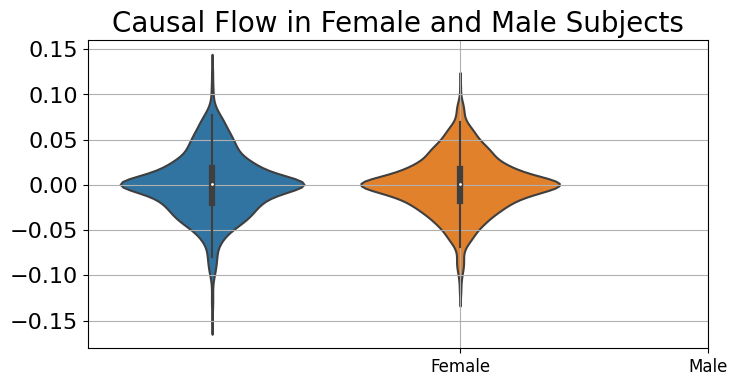

In [33]:
causal_flow_subnetwork_female = np.array(X_causal_flow)[female_idx,:].flatten()
causal_flow_subnetwork_male = np.array(X_causal_flow)[male_idx,:].flatten()

plt.figure(figsize = (8,4))
violin_parts = sns.violinplot([causal_flow_subnetwork_female,causal_flow_subnetwork_male], showmedians = True, showextrema = True )
plt.grid()
plt.title('Causal Flow in Female and Male Subjects', fontsize = 20)
plt.xticks(np.arange(1,3), labels = ['Female', 'Male'], rotation = 'horizontal',fontsize = 12)
h = plt.yticks(fontsize = 16)

test = scipy.stats.ranksums(causal_flow_subnetwork_female, causal_flow_subnetwork_male, alternative='two-sided')
print(test)